![](header.png)

# Stereo Produced Pointcloud

Kevin J. Walchko

27 Feb 2021

---

## References

- [Producing 3D point clouds with a stereo camera in OpenCV](https://erget.wordpress.com/2014/04/27/producing-3d-point-clouds-with-a-stereo-camera-in-opencv/)
- stackexchange: [How to obtain dense point clouds from stereo cameras?](https://robotics.stackexchange.com/questions/445/how-to-obtain-dense-point-clouds-from-stereo-cameras)
- [stereo calibration and pointcloud](http://amroamroamro.github.io/mexopencv/opencv/stereo_calibration_demo.html)

## Reprojecting to Disparity to 3D Point Cloud

Disparities maps (x-x') can be reprojected to 3d:

\begin{eqnarray}
    Z = \frac{fT_x}{x-x'}
\end{eqnarray}

During stereo calibration (`cv2.stereoCalibrate()`), there is a Q matrix which is produced. This can also reproject image points to world points using the `cv2.reprojectImageTo3d()`:

\begin{eqnarray}
    \begin{bmatrix}
        X & Y & Z & W
    \end{bmatrix}^T = Q \begin{bmatrix} x & y & d & 1 \end{bmatrix}^T \\
    Q = \begin{bmatrix}
        1 & 0 & 0 & -c_x \\
        0 & 1 & 0 & -c_y \\
        0 & 0 & 0 & f \\
        0 & 0 & -1/T_x & (c_x - c_x')/T_x
    \end{bmatrix}
\end{eqnarray}

Now the true 3D points are X/W, Y/W, and Z/W. If `CV_CALIB_ZERO_DISPARITY` is set, then $c_x = c_x'$ and the value in the lower right corner of Q is 0. Doing a little bit of algebra on the equations above leads you to:

\begin{eqnarray}
     Q \begin{bmatrix} x & y & d & 1 \end{bmatrix}^T = 
     \begin{bmatrix}
         \frac{-Tx (x - c_x)}{d} \\
         \frac{-Tx (y - c_y)}{d} \\
         \frac{-f T_x}{d}
     \end{bmatrix} = \begin{bmatrix} X & Y & Z \end{bmatrix}^T
\end{eqnarray}

If you look at the first equation for depth (Z) above and compare it to the last, they are the same. From a units stand point, for X, Y and Z and assuming the translation ($T_x$) units were meters (m), you end up with $\frac{m*px}{px} \Rightarrow m$. Thus your units have to be:

| Parameter               | Units  |
|-------------------------|--------|
| Baseline ($T_x$)        | meters |
| Focal length ($f$)      | pixels | 
| Principle point ($c_x$) | pixels |
| Disparity (d)           | pixels |

You can produce the 3D points using:

- `cv2.perspectiveTransform()`: this transforms an array of points to 3D space
- `cv2.reprojectImageTo3D()`: this transforms a whole disparity image

In [5]:
import cv2
from opencv_camera import bgr2gray, gray2bgr, bgr2rgb
from matplotlib import pyplot as plt
import numpy as np 
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [2]:

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
 
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'w') as f:
        f.write(ply_header % dict(vert_num=len(verts)))
        np.savetxt(f, verts, '%f %f %f %d %d %d')


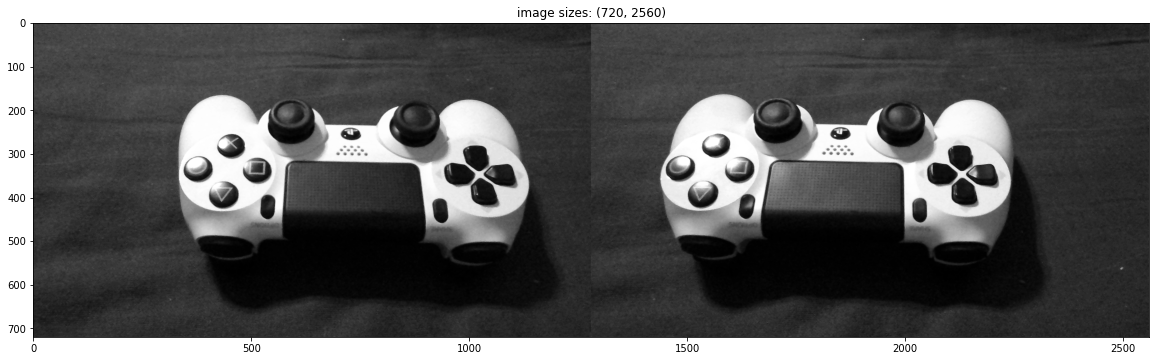

In [14]:

tmp = cv2.imread('image-7.png',0)

plt.subplots(1,1,figsize=(20,10))
plt.imshow(tmp, cmap="gray");
plt.title(f"image sizes: {tmp.shape}");

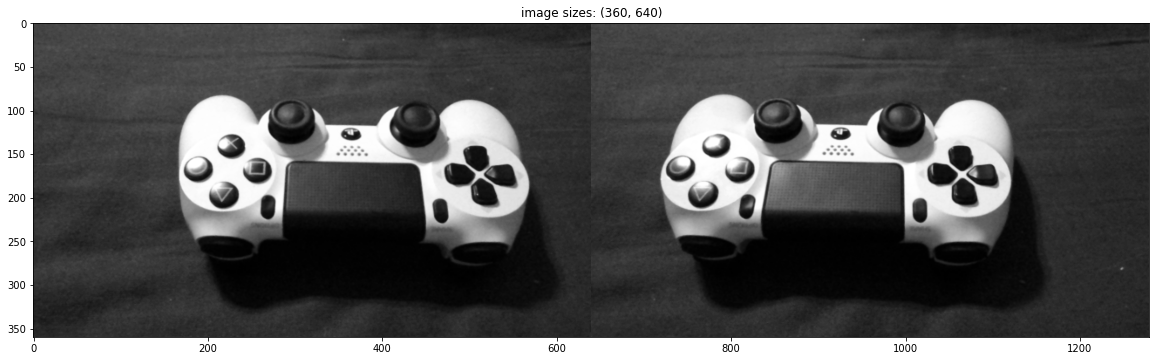

In [18]:
# get grayscale left/right image and downscale
# the image to speedup processing
tmp = cv2.imread('image-7.png',0)
_, cols = tmp.shape[:2]
imgL = cv2.pyrDown(tmp[:,:cols//2])
imgR = cv2.pyrDown(tmp[:,cols//2:])

plt.subplots(1,1,figsize=(20,10))
plt.imshow(np.hstack((imgL, imgR)), cmap="gray");
plt.title(f"image sizes: {imgL.shape}");

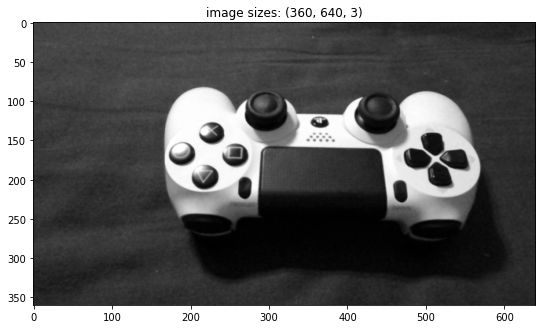

In [19]:
# grab a color version too
colors = cv2.pyrDown(cv2.imread('image-7.png'))
colors = bgr2rgb(colors)
_, cols = colors.shape[:2]
colors = colors[:,:cols//2,:]

plt.subplots(1,1,figsize=(9,9))
plt.imshow(colors);
plt.title(f"image sizes: {colors.shape}");

In [20]:
# disparity range is tuned for 'aloe' image pair
window_size = 3
min_disp = 16*1
num_disp = 16*8-min_disp
stereo = cv2.StereoSGBM_create(
    minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = 16,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 10,
    speckleWindowSize = 100,
    speckleRange = 32
)

print('computing disparity...')
disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

computing disparity...


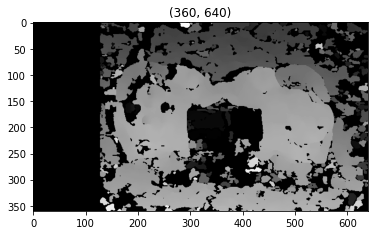

In [21]:
dm = (disp-min_disp)/num_disp
plt.imshow(dm, cmap="gray")
plt.title(dm.shape);

In [23]:
print('generating 3d point cloud...')
h, w = imgL.shape[:2]
t = 0.035   # baseline in meters
f = 0.8*w   # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0, 1, 0, -0.5*h],
                [0, 0, 0,      f],
                [0, 0,-1/t,    0]])
points = cv2.reprojectImageTo3D(disp, Q)
mask = disp > disp.min()
out_points = points[mask]
out_colors = colors[mask]

if 0:
    out_fn = 'ps4-controller-2.ply'
    write_ply(out_fn, out_points, out_colors)
    print(f'{out_fn} saved')

generating 3d point cloud...
ps4-controller.ply saved


Reading the *ply* file with meshlab shows pretty good results:

![](ply.png)

## Matplotlib

Unfortunately, displaying in `Matplotlib` and spinning the pointcloud so you can see something is painfully slow. In the end, it doesn't look as good as Apple's Preview or Meshlab.

In [26]:
from mpl_toolkits.mplot3d import Axes3D 

<IPython.core.display.Javascript object>


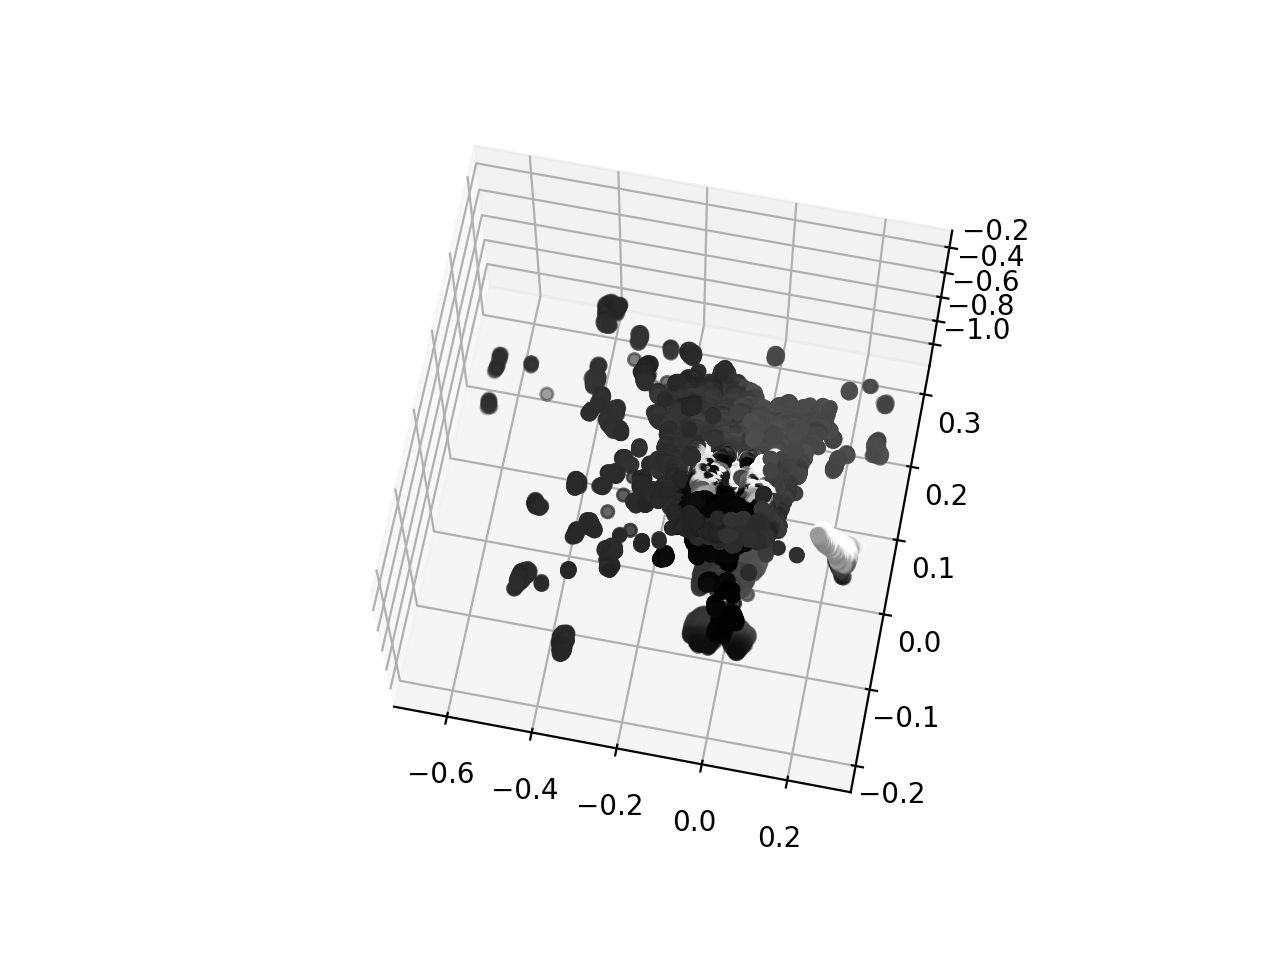

In [40]:
%matplotlib notebook

# fig = plt.figure(figsize=(20,10))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(out_points[:,0], out_points[:,1], out_points[:,2], c=out_colors/255.0)